# Шаг 1. Откройте файлы с данными

In [1]:
# pip install -U catboost

## Импроты

In [2]:
import warnings
warnings.filterwarnings("ignore")

import copy

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 9)

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve

## Функции

In [3]:
def get_hist_box(df, num_feat_name):
    """
    Изображает диаграмму распределения и ящики с усами числового признака
    num_feat_name с разделением по признаку 'is_canceled'.
    Возвращает оси (ax_hist и ax_box), в которых изображены гистограмма
    и ящики с усами.
    """
    fig, (ax_hist,
          ax_box) = plt.subplots(2,
                                 sharex=True,
                                 gridspec_kw={"height_ratios": (.70, .30)})

    sns.histplot(data=df,
                 x=num_feat_name,
                 hue='is_canceled',
                 ax=ax_hist,
                 stat='density',
                 kde=True)

    ax_hist.legend(['Отменена', 'Не отменена'], title='Бронь', fontsize='15')
    ax_hist.set_ylabel('Плотность', fontsize=15)
    plt.setp(ax_hist.get_legend().get_title(), fontsize='18')

    sns.boxplot(data=df, x=num_feat_name, y='is_canceled_cat', ax=ax_box)
    ax_box.set_ylabel('Статус брониварония', fontsize=15)
    ax_box.set_xlabel('Время, дни', fontsize=15)
    ax_box.set_yticklabels(['Не отменено', 'Отменено'])
    return (ax_hist, ax_box)

In [4]:
def get_count_heat(df, cat_feat_name):
    """
    Изображает столбчатую диаграмму и тепловую карту, на которой изображено
    насколько сильно отклоняется соотношение класов 1 и 0 от среднего значения
    по выборке df для категориального признака cat_feat_name c разделением 
    по признаку 'is_canceled'. Возвращает оси ax_count, в которых
    изображена диаграмма.
    """
    df_grouped = (df
                  .groupby(cat_feat_name)['is_canceled']
                  .mean()
                  .sort_values(ascending=False)) - df['is_canceled'].mean()

    fig, (ax_count, ax_heat) = plt.subplots(2,
                                  sharex=False,
                                  gridspec_kw={"height_ratios": (.85, .15)})

    sns.countplot(data=df,
                  hue='is_canceled',
                  x=cat_feat_name,
                  ax=ax_count,
                  order=df_grouped.index)
    ax_count.legend(['Не отменена', 'Отменена'], title='Бронь', fontsize=12, loc='upper right')
    ax_count.set_ylabel('Количество бронирований', fontsize=15)

    sns.heatmap(df_grouped.values.reshape(1, -1),
                annot=True,
                cbar=False,
                fmt='.2%',
                ax=ax_heat,
                xticklabels=df_grouped.index,
                yticklabels=['Отличие от среднего'])
    return ax_count

In [5]:
def calculate_profit(df, with_pred=False, pred_feat_name='lr_predictions'):
    """
    Расчитывает бизнес-метрику данный задачи.
    Возвращает вещественное число - прибыль с одного конкретного бронирования row.
    """
    df['night_price'] = df['reserved_room_type'].apply(lambda x: ROOM_PRICE[x][0])
    df['service_price'] = df['reserved_room_type'].apply(lambda x: ROOM_PRICE[x][1])

    df['profit'] = 0

    zeros = list(df.query('is_canceled == 0').index)
    ones = list(df.query('is_canceled == 1').index)

    df.loc[zeros, 'profit'] = (
        df['arrival_date_season_coef'] *
        (df['total_nights'] * df['night_price'] -
         df['service_price'] * (df['total_nights'] // 2 + 1)))

    df.loc[ones, 'profit'] = (
        -df['arrival_date_season_coef'] *
        (df['night_price'] + df['service_price']))
    
    if with_pred:
        true_ones = list(df[(df[pred_feat_name] == 1) & (df['is_canceled'] == 1)].index)
        df.loc[true_ones, 'profit'] *= 0.2

In [6]:
def plot_roc_auc(y, pred):
    """
    Изображает ROC-кривую.
    """
    fpr, tpr, _ = roc_curve(y, pred)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label='ROC-AUC = %0.4f' % roc_auc_score(y, pred),
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC кривая")
    plt.legend(loc="lower right")
    plt.show()

In [7]:
def tune_threshold(y_true, predictions_proba):
    """
    Настравает порог отсечки для максимизации F1-меры.
    Возвращает предсказания threshold_predictions и выбранную
    лучшую отсечку threshold_best.
    """
    threshold_best = 0
    f1_best = 0
    for threshold in np.arange(0.01, 1, 0.01):
        threshold_predictions_i = (predictions_proba > threshold).astype(int)
        res = f1_score(y_true, threshold_predictions_i)
        if res > f1_best:
            f1_best = res
            threshold_best = threshold
            threshold_predictions = threshold_predictions_i
    print(f'Лучший порог: {threshold_best}\nЛучшая f1-мера: {f1_best}')
    return threshold_predictions, threshold_best

## Константы

In [8]:
ROOM_PRICE = {
        room_type: price
        for room_type, price in zip(range(7), [(350, 150),
                                               (450, 150),
                                               (500, 150),
                                               (550, 150),
                                               (600, 350),
                                               (800, 350),
                                               (1000, 400)])}

BUDGET = 400_000

## Данные

In [9]:
try:
    train = pd.read_csv('hotel_train.csv')
    test = pd.read_csv('hotel_test.csv')
except:
    train = pd.read_csv('/datasets/hotel_train.csv')
    test = pd.read_csv('/datasets/hotel_test.csv')

In [10]:
train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [11]:
test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


## Описание данных

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:  
`id` — номер записи;  
`adults` — количество взрослых постояльцев;  
`arrival_date_year` — год заезда;  
`arrival_date_month` — месяц заезда;  
`arrival_date_week_number` — неделя заезда;  
`arrival_date_day_of_month` — день заезда;  
`babies` — количество младенцев;  
`booking_changes` — количество изменений параметров заказа;  
`children` — количество детей от 3 до 14 лет;  
`country` — гражданство постояльца;  
`customer_type` — тип заказчика:  
- Contract — договор с юридическим лицом;  
- Group — групповой заезд;  
- Transient — не связано с договором или групповым заездом;  
- Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.  

`days_in_waiting_list` — сколько дней заказ ожидал подтверждения;  
`distribution_channel` — канал дистрибуции заказа;  
**`is_canceled` — отмена заказа - ЦЕЛЕВОЙ;**  
`is_repeated_guest` — признак того, что гость бронирует номер второй раз;  
`lead_time` — количество дней между датой бронирования и датой прибытия;  
`meal` — опции заказа:  
- SC — нет дополнительных опций;  
- BB — включён завтрак;  
- HB — включён завтрак и обед;  
- FB — включён завтрак, обед и ужин. 

`previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;  
`previous_cancellations` — количество отменённых заказов у клиента;  
`required_car_parking_spaces` — необходимость места для автомобиля;  
`reserved_room_type` — тип забронированной комнаты;  
`stays_in_weekend_nights` — количество ночей в выходные дни;  
`stays_in_week_nights` — количество ночей в будние дни;  
`total_nights` — общее количество ночей;  
`total_of_special_requests` — количество специальных отметок.

# Шаг 2. Предобработка и исследовательский анализ данных

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

**ВЫВОД:**  
Пропусков нет. Типы данных верные.

## Уникальные значения в датасете

In [14]:
train.nunique()

id                                65229
is_canceled                           2
lead_time                           369
arrival_date_year                     2
arrival_date_month                   12
arrival_date_week_number             53
arrival_date_day_of_month            31
stays_in_weekend_nights               5
stays_in_week_nights                  7
adults                                5
children                              4
babies                                5
meal                                  5
country                             155
distribution_channel                  4
is_repeated_guest                     2
previous_cancellations               15
previous_bookings_not_canceled       58
reserved_room_type                    7
booking_changes                      16
days_in_waiting_list                 97
customer_type                         4
required_car_parking_spaces           4
total_of_special_requests             6
total_nights                         10


In [15]:
test.nunique()

id                                32412
is_canceled                           2
lead_time                           368
arrival_date_year                     1
arrival_date_month                    8
arrival_date_week_number             35
arrival_date_day_of_month            31
stays_in_weekend_nights               5
stays_in_week_nights                  7
adults                                5
children                              4
babies                                3
meal                                  5
country                             143
distribution_channel                  4
is_repeated_guest                     2
previous_cancellations                7
previous_bookings_not_canceled       46
reserved_room_type                    7
booking_changes                      15
days_in_waiting_list                 75
customer_type                         4
required_car_parking_spaces           5
total_of_special_requests             6
total_nights                         10


In [16]:
set(train['id']) & set(test['id'])

set()

**ВЫВОД:**  
`id` - уникален и не пересекается в трейне и тесте.

Удалим столбец `id`.

In [17]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

## Дубликаты

In [18]:
full_train = copy.deepcopy(train)

a = train.shape[0]
train = train.drop_duplicates()
print(f'Удалено {a-train.shape[0]} полных дубликатов.')

Удалено 21377 полных дубликатов.


Исследовательский анализ проведем на наборе данных без дубликатов.  
Сохраним для экспериментов как полные данные, так и данные без дубликатов.

## Баланс классов

In [19]:
print('Отношение классов в обучающей выборке без дубликатов:', train['is_canceled'].mean())

Отношение классов в обучающей выборке без дубликатов: 0.25421873574751436


In [20]:
print('Отношение классов в тестовой выборке:',test['is_canceled'].mean())

Отношение классов в тестовой выборке: 0.3884672343576453


In [21]:
print('Отношение классов в обучающей выборке:', full_train['is_canceled'].mean())

Отношение классов в обучающей выборке: 0.3686090542550093


**ВЫВОД:**  
Наблюдается дисбаланс классов.  
В трейне и тесте отношение классов различается из-за наличия дубликатов.

## Время между бронью и прибытием

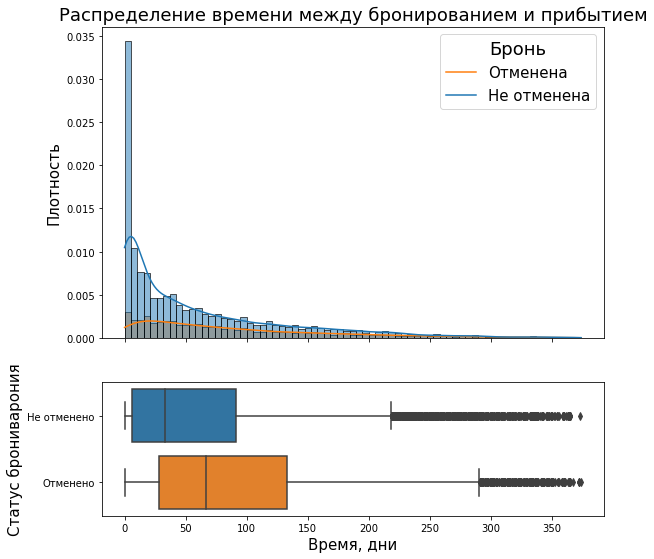

In [22]:
train['is_canceled_cat'] = train['is_canceled'].astype('category')

ax1, ax2 = get_hist_box(train, 'lead_time')
ax1.set_title('Распределение времени между бронированием и прибытием',
                  fontsize=18)
plt.show()

**ВЫВОД:**  
Чем меньше дней от бронирования до заселения, тем реже отменяется бронирование.

## Год прибытия

In [23]:
train['arrival_date_year'].unique()

array([2015, 2016], dtype=int64)

In [24]:
test['arrival_date_year'].unique()

array([2017], dtype=int64)

**ВЫВОД:**  
Год не информативен, поскольку в тесте нет 2015 и 2016 годов.

Удалим столбец `arrival_date_year`.

In [25]:
full_train = full_train.drop('arrival_date_year', axis=1)
train = train.drop('arrival_date_year', axis=1)

test = test.drop('arrival_date_year', axis=1)

## Месяц и неделя прибытия

In [26]:
train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [27]:
test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [28]:
train['arrival_date_week_number'].unique()

array([27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26], dtype=int64)

In [29]:
test['arrival_date_week_number'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35], dtype=int64)

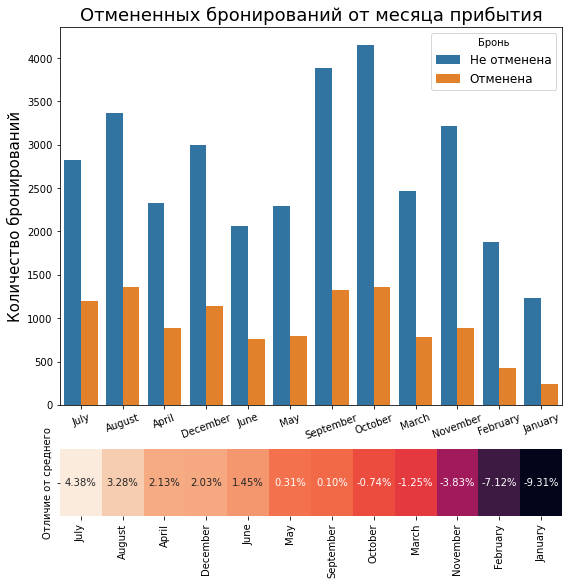

In [30]:
ax = get_count_heat(train, 'arrival_date_month')

ax.set_title('Отмененных бронирований от месяца прибытия',
                   fontsize=18)
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=20)

plt.show()

**ВЫВОД:**  
В тесте нет осенних месяцев (недель) и декабря.  
Чаще всего бронирования отменяют на июль, август и апрель, реже всего на январь, февраль и ноябрь.  
Особенно интересны те месяцы, процент отмен в которых сильно отличается от баланса классов (25,42%).  
Здесь и далее на тепловой карте отражено *отличие % отмен бронирования в определенной категории от % отмен по всему датасету*.

## Сезон прибытия

Введем новый признак: коэффициент времени года в соответствии с месяцем прибытия.

In [31]:
train['arrival_date_season_coef'] = (
    np.where(train['arrival_date_month'].isin(['December', 'January', 'February']), 
             1, 
             np.where(
                 train['arrival_date_month'].isin(['March', 'April', 'May']), 
                 1.2, 
                 np.where(
                     train['arrival_date_month'].isin(['June', 'July', 'August']),
                     1.4, 
                     1.2))))

In [32]:
train.loc[:, ['arrival_date_season_coef', 'arrival_date_month']].sample(5)

,arrival_date_season_coef,arrival_date_month
1680,1.2,October
58056,1.4,August
41004,1.2,September
45901,1.0,January
9746,1.0,January


In [33]:
test['arrival_date_season_coef'] = (
    np.where(test['arrival_date_month'].isin(['December', 'January', 'February']), 
             1, 
             np.where(
                 test['arrival_date_month'].isin(['March', 'April', 'May']), 
                 1.2, 
                 np.where(
                     test['arrival_date_month'].isin(['June', 'July', 'August']),
                     1.4, 
                     1.2))))

In [34]:
test.loc[:, ['arrival_date_season_coef', 'arrival_date_month']].sample(5)

,arrival_date_season_coef,arrival_date_month
25328,1.2,May
8340,1.0,January
29753,1.4,July
26012,1.2,May
21045,1.0,February


**ЗАМЕЧАНИЕ:**  
- В столбцах `arrival_date_month` и `arrival_date_week_number` информация дублируется, поэтому один из них можно удалить. Логично будет оставить месяц и день приезда, а номер недели удалить.  
- `arrival_date_season` также дублирует информацию из `arrival_date_month`, поэтому этот признак в построении модели участовать не будет, но он понадобится при расчете прибыли.

In [35]:
full_train = full_train.drop('arrival_date_week_number', axis=1)
train = train.drop('arrival_date_week_number', axis=1)

test = test.drop('arrival_date_week_number', axis=1)

## Количество взрослых, детей и младенцев

### Взрослые

In [36]:
train['adults'].value_counts()

2.0    32299
1.0     8688
3.0     2688
0.0      164
4.0       13
Name: adults, dtype: int64

In [37]:
test['adults'].value_counts()

2.0    24237
1.0     6280
3.0     1817
0.0       69
4.0        9
Name: adults, dtype: int64

Объединим 3 и 4 взрослых в одну категорию "больше 2". Закодируем числом 3.  
Будем считать, что невозможно снять номер только для детей, поэтому значения 0 - ошибочны и должны быть удалены.

In [38]:
zero_adults = train[train['adults'] == 0].index

full_train = full_train.drop(zero_adults)
train = train.drop(zero_adults)

full_train['adults'] = full_train['adults'].replace(to_replace=4, value=3)
train['adults'] = train['adults'].replace(to_replace=4, value=3)
test['adults'] = test['adults'].replace(to_replace=4, value=3)

In [39]:
train['adults'].value_counts()

2.0    32299
1.0     8688
3.0     2701
Name: adults, dtype: int64

In [40]:
test['adults'].value_counts()

2.0    24237
1.0     6280
3.0     1826
0.0       69
Name: adults, dtype: int64

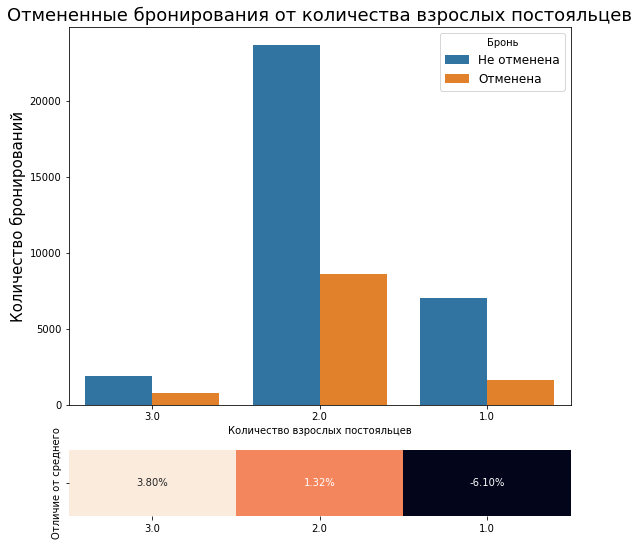

In [41]:
ax = get_count_heat(train, 'adults')

ax.set_title(
    'Отмененные бронирования от количества взрослых постояльцев', fontsize=18)
ax.set_xlabel('Количество взрослых постояльцев')

plt.show()

**ВЫВОД:**  
Чаще всего отменяют бронь большие компании взрослых гостей.  
Количество взрослых прямопропорционально вероятности отмены.  
Большинство клиентов бронируют номер для двух взрослых.

### Дети

In [42]:
train['children'].value_counts()

0.0    40456
1.0     2058
2.0     1166
3.0        8
Name: children, dtype: int64

In [43]:
test['children'].value_counts()

0.0    30360
1.0     1394
2.0      653
3.0        5
Name: children, dtype: int64

Объединим категории 2 и 3 в категорию >1. Закодируем числом 2.

In [44]:
full_train['children'] = full_train['children'].replace(to_replace=3, value=2)
train['children'] = train['children'].replace(to_replace=3, value=2)

test['children'] = test['children'].replace(to_replace=3, value=2)

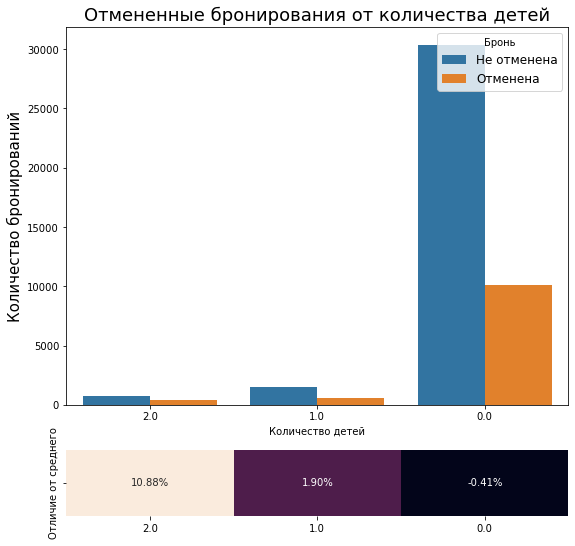

In [45]:
ax = get_count_heat(train, 'children')

ax.set_title('Отмененные бронирования от количества детей',
                   fontsize=18)
ax.set_xlabel('Количество детей')

plt.show()

**ВЫВОД:**   
Клиенты c более чем одним ребенком отменяют бронь чаще остальных.  
Большинство клиентов приезжают без детей. Процент отмен среди них не отличается от среднего по выборке.

### Младенцы

In [46]:
train['babies'].value_counts()

0.0     43242
1.0       441
2.0         3
10.0        1
9.0         1
Name: babies, dtype: int64

In [47]:
test['babies'].value_counts()

0.0    32237
1.0      171
2.0        4
Name: babies, dtype: int64

9 и 10 младенцев - выбросы.

In [48]:
outliers = train[train['babies'] > 2].index
full_train = full_train.drop(outliers)
train = train.drop(outliers)

Выбросы устранены.

Объединим категории 2 и 1 в одну. Таким образом, получим бинарный признак "путеществует с младенцем".

In [49]:
full_train['babies'] = full_train['babies'].replace(to_replace=2, value=1)
train['babies'] = train['babies'].replace(to_replace=2, value=1)

test['babies'] = test['babies'].replace(to_replace=2, value=1)

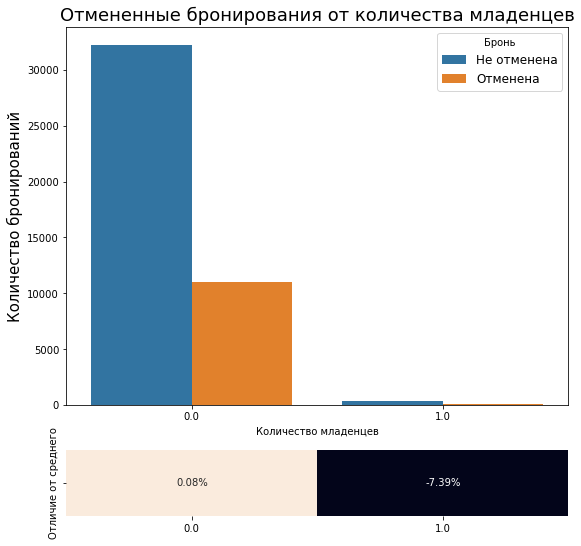

In [50]:
ax = get_count_heat(train, 'babies')

ax.set_title('Отмененные бронирования от количества младенцев',
                   fontsize=18)
ax.set_xlabel('Количество младенцев')

plt.show()

**РЕЗУЛЬТАТ:**  
Не слишком информативный признак. Количество постольцев с младенцами крайне мало, а процент отмен среди пстояльцев без младенцев на руках не отличается от процента по всей выборке.

## Продолжительность отдыха

In [51]:
train['stays_in_weekend_nights'].value_counts()

0    18312
2    12895
1    12123
3      211
4      145
Name: stays_in_weekend_nights, dtype: int64

In [52]:
train['stays_in_week_nights'].value_counts()

1    12115
2    11045
3     8578
5     4313
4     4027
0     3045
6      563
Name: stays_in_week_nights, dtype: int64

In [53]:
train['total_nights'].value_counts()

3     9588
1     9338
2     8415
4     7179
5     3580
7     3275
6     1598
8      476
9      123
10     114
Name: total_nights, dtype: int64

In [54]:
train.query("stays_in_week_nights + stays_in_weekend_nights != total_nights")

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,is_canceled_cat,arrival_date_season_coef


Никто не остается дольше, чем на 10 ночей.  
Для всех объектов верно `stays_in_week_nights` + `stays_in_weekend_nights` == `total_nights`. Соответственно, эти признаки линейнозависимы, что плохо скажется на качестве линейных моделей. Для моделей на деревьях решений, эти признаки не будут нести существенной информации.  
Исключим `total_nights` из построения модели непосредственно перед обучением, потому что этот столбец еще понадобится при расчете бизнес-метрики.

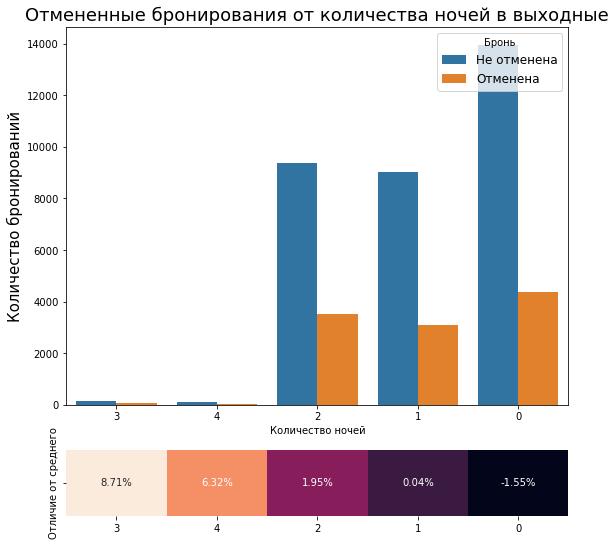

In [55]:
ax = get_count_heat(train, 'stays_in_weekend_nights')
ax.set_title('Отмененные бронирования от количества ночей в выходные',
                   fontsize=18)
ax.set_xlabel('Количество ночей')
plt.show()

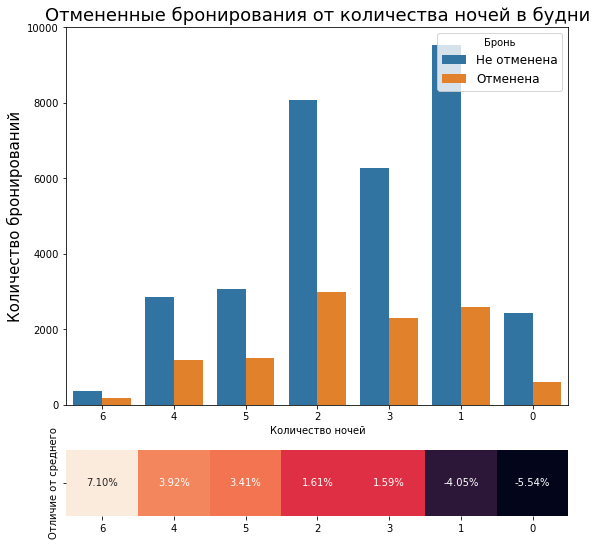

In [56]:
ax = get_count_heat(train, 'stays_in_week_nights')
ax.set_title('Отмененные бронирования от количества ночей в будни',
                   fontsize=18)
ax.set_xlabel('Количество ночей')
plt.show()

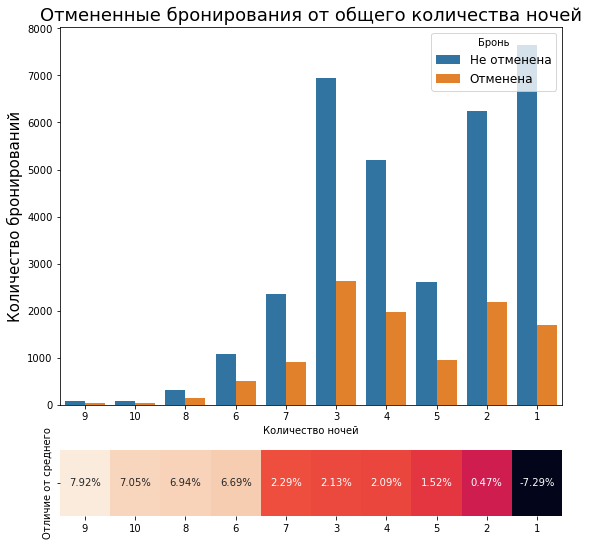

In [57]:
ax = get_count_heat(train, 'total_nights')
ax.set_title('Отмененные бронирования от общего количества ночей',
                   fontsize=18)
ax.set_xlabel('Количество ночей')
plt.show()

**ВЫВОД:**  
Чаще всего отменяют бронирования на большой срок - больше недели.  
Бронирования на один день отменяют реже всего.

## Питание

In [58]:
train['meal'].value_counts()

BB           35401
SC            4656
HB            3341
SC             153
FB             135
Name: meal, dtype: int64

In [59]:
test['meal'].value_counts()

BB           24684
SC            5035
HB            2399
SC             258
FB              36
Name: meal, dtype: int64

Устарним лишние пробелы.

In [60]:
full_train['meal'] = full_train['meal'].str.strip()
train['meal'] = train['meal'].str.strip()

test['meal'] = test['meal'].str.strip()

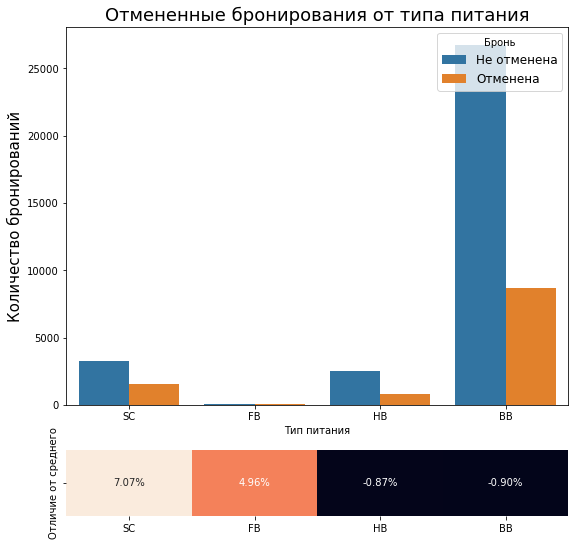

In [61]:
ax = get_count_heat(train, 'meal')
ax.set_title('Отмененные бронирования от типа питания', fontsize=18)
ax.set_xlabel('Тип питания')
plt.show()

Большинство гостей выбирают только завтрак. Отмены здесь не отличаются от отмен по всему датасету.  
Далее по количеству бронирований следуют "завтрак+обед". Отмены в этой категории также не отличаются от среднего значения.  
Наибольшая доля отмен приходится на отсутствие питания и на трехразовое питание.

## Гражданство постояльца

In [62]:
train['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

Уникальных стран слишком много. Объединим те, для которых количество гостей в обучающей выборке не превышает 1% от размера выборки, в одну категорию "Другое".

In [63]:
tmp = full_train['country'].value_counts()
top_freq_country = list(tmp[tmp > (len(full_train) * 0.01)].index)

In [64]:
full_train['country'] = np.where(full_train['country'].isin(top_freq_country),
                                 full_train['country'],
                                 'OTHER')
train['country'] = np.where(train['country'].isin(top_freq_country),
                            train['country'],
                            'OTHER')

test['country'] = np.where(test['country'].isin(top_freq_country),
                           test['country'],
                           'OTHER')

In [65]:
train['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'OTHER', 'USA', 'DEU', 'BEL',
       'CHE', 'NLD', 'ITA', 'BRA', 'AUT'], dtype=object)

In [66]:
test['country'].unique()

array(['PRT', 'AUT', 'BEL', 'DEU', 'BRA', 'GBR', 'ESP', 'FRA', 'ITA',
       'OTHER', 'CHE', 'IRL', 'NLD', 'USA'], dtype=object)

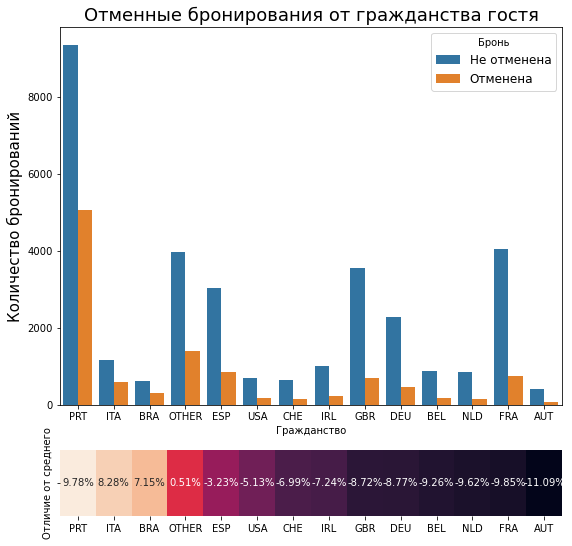

In [67]:
ax = get_count_heat(train, 'country')
ax.set_title('Отменные бронирования от гражданства гостя', fontsize=18)
ax.set_xlabel('Гражданство')
plt.show()

**ВЫВОД:**  
Количество категорий значительно уменьшилось.  
Больше одной трети гостей из Португалии и Италии отменяют бронирование. Реже всех отменяют бронь австрийцы и французы - около 15% постояльцев из этих стран.

## Канал распространения

In [68]:
train['distribution_channel'].value_counts()

TA/TO        35043
Direct        5800
Corporate     2753
GDS             90
Name: distribution_channel, dtype: int64

In [69]:
test['distribution_channel'].value_counts()

TA/TO        27083
Direct        3642
Corporate     1602
GDS             85
Name: distribution_channel, dtype: int64

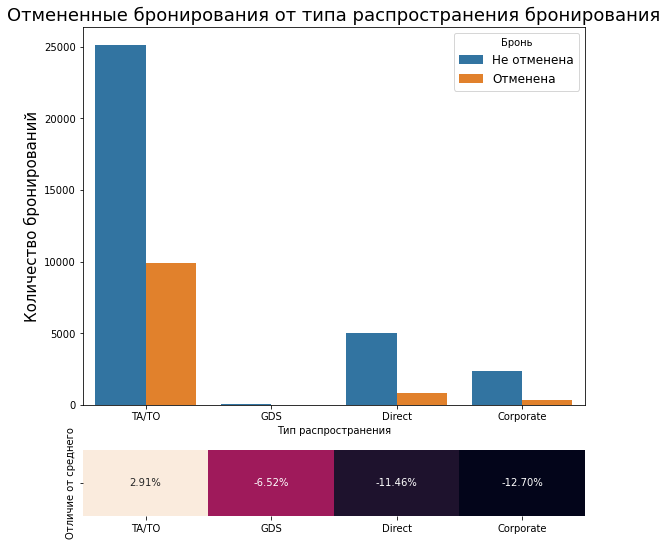

In [70]:
ax = get_count_heat(train, 'distribution_channel')
ax.set_title('Отмененные бронирования от типа распространения бронирования', fontsize=18)
ax.set_xlabel('Тип распространения')

plt.show()

**ВЫВОД:**  
Гости, которые забронировали отель через туроператора или туристическое агенство, отменяют бронь более чем в чаще других.  
Те, для кого отель бронирует организация, отменяют бронь реже всех.

## Повторное бронирование

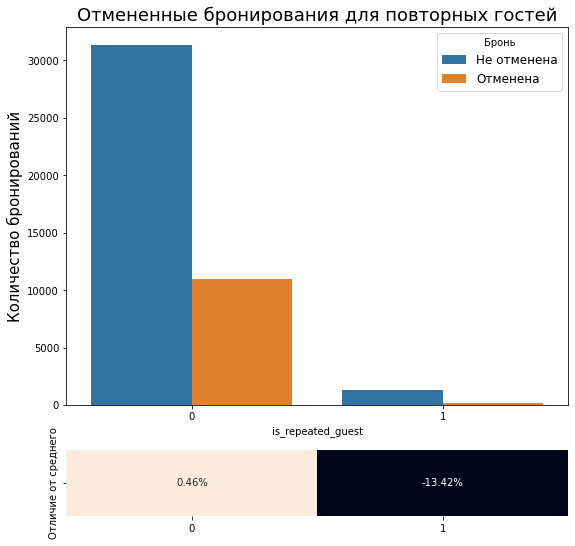

In [71]:
ax = get_count_heat(train, 'is_repeated_guest')
ax.set_title('Отмененные бронирования для повторных гостей', fontsize=18)
plt.show()

**ВЫВОД:**  
Повторные гости очень редко отменяют бронирование.

## Предыдущие заказы

Сформируем 4 группы клиентов:  
1. Нет отмененных, нет подтвержденных - закодируем 0;
2. Нет отмененных, есть подтвержденные - закодируем 1; 
3. Есть отмененные, нет подтвержденных - закодируем 2;  
4. Есть как отмененные, так и подтвержденные - закодируем 3.  
  
Рассмотрим отличие вероятности их бронирования от средней.

Преобразуем в бинарные признаки: "ранее отменял бронирование", "есть подтвержденные бронирования".

In [72]:
full_train['previous_cancellations_bool'] = np.where(full_train['previous_cancellations'] > 0,
                                                     1,
                                                     0)
train['previous_cancellations_bool'] = np.where(train['previous_cancellations'] > 0,
                                                1,
                                                0)
test['previous_cancellations_bool'] = np.where(test['previous_cancellations'] > 0,
                                               1,
                                               0)

full_train['previous_bookings_not_canceled_bool'] = np.where(full_train['previous_bookings_not_canceled'] > 0,
                                                             1,
                                                             0)
train['previous_bookings_not_canceled_bool'] = np.where(train['previous_bookings_not_canceled'] > 0,
                                                        1,
                                                        0)
test['previous_bookings_not_canceled_bool'] = np.where(test['previous_bookings_not_canceled'] > 0,
                                                       1,
                                                       0)

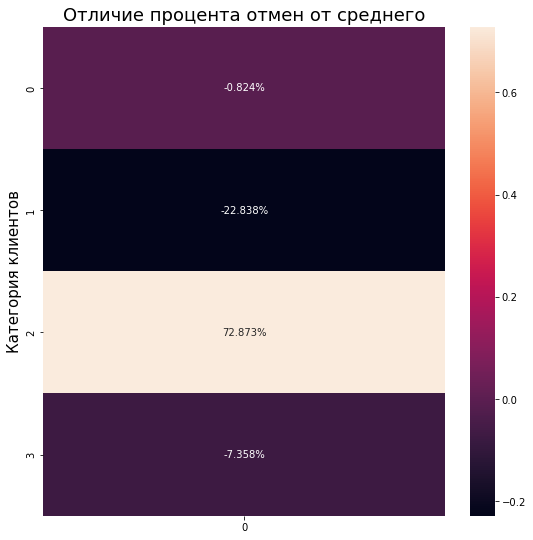

In [73]:
q = (train
     .groupby(['previous_cancellations_bool',
               'previous_bookings_not_canceled_bool'])['is_canceled']
     .mean() - train['is_canceled'].mean())

sns.heatmap(q.values.reshape(-1, 1),
            annot=True,
            fmt='.3%',
            yticklabels=range(4))

plt.title('Отличие процента отмен от среднего', fontsize=18)
plt.ylabel('Категория клиентов', fontsize=15)
plt.show()

Сравним с аналогичной величиной для тестовой выборки.

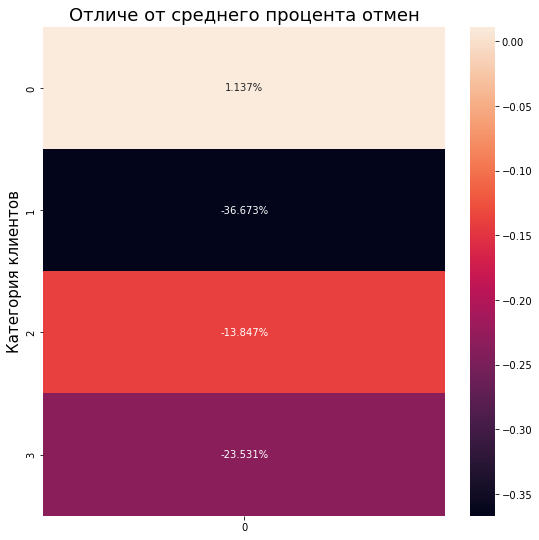

In [74]:
q = (test
     .groupby(['previous_cancellations_bool',
               'previous_bookings_not_canceled_bool'])['is_canceled']
     .mean() - test['is_canceled'].mean())

sns.heatmap(q.values.reshape(-1, 1),
            annot=True,
            fmt='.3%',
            yticklabels=range(4))

plt.title('Отличе от среднего процента отмен', fontsize=18)
plt.ylabel('Категория клиентов', fontsize=15)
plt.show()

In [75]:
test.query("previous_cancellations_bool == 1 and previous_bookings_not_canceled_bool == 0")

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,arrival_date_season_coef,previous_cancellations_bool,previous_bookings_not_canceled_bool
2179,0,80.0,June,9,2,2,2.0,0.0,0.0,FB,...,F,1,0,Transient,0,0,4,1.4,1,0
2198,1,5.0,July,13,0,1,1.0,0.0,0.0,BB,...,D,0,0,Transient,0,0,1,1.4,1,0
18156,0,4.0,March,7,0,1,2.0,0.0,0.0,BB,...,D,0,0,Transient,0,1,1,1.2,1,0
18172,0,2.0,February,9,0,2,1.0,0.0,0.0,BB,...,A,2,0,Transient,0,1,2,1.0,1,0


**ВЫВОД:**  
Наблюдается вполне логичные закономерности:  
1. Новые клиенты имеют среднюю вероятность отменить бронь.  
2. Те, кто ранее не отменял бронирования, и имеет подтвержденные, с высокой вероятностью подтвердят бронирование снова. Это лояльные клиенты.  
3. Клиенты, которые ранее отменяли свои бронирования, и ни одного не подтверждали - высоковероятно отменят бронирование и в этот раз. Можно сказать, что это не справедливо для тестовой выборки, но, если рассмотреть внимательнее эту группу клиентов, мы заметим, что их количество крайне мало, а значит не репрезентативно.  
4. Люди, которые как отменяли, так и подтверждали бронирование, больше склонны отменить его снова. Вероятно, стоит собрать у них обратную связь и узнать, что их не устраивает.

Исключим признаки с количеством бронирований или отмен.

In [76]:
full_train = full_train.drop(['previous_cancellations', 'previous_bookings_not_canceled'], axis=1)
train = train.drop(['previous_cancellations', 'previous_bookings_not_canceled'], axis=1)

test = test.drop(['previous_cancellations', 'previous_bookings_not_canceled'], axis=1)

## Тип забронированного номера

In [77]:
train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [78]:
train['reserved_room_type'].value_counts()

A                   30431
D                    8420
E                    2251
F                    1176
B                     601
G                     580
C                     227
Name: reserved_room_type, dtype: int64

In [79]:
test['reserved_room_type'].value_counts()

A                   23471
D                    6123
E                    1644
F                     503
G                     278
C                     201
B                     192
Name: reserved_room_type, dtype: int64

Удалим лишние пробелы и закодируем по убыванию цены А = 6 .. G = 0.

In [80]:
full_train['reserved_room_type'] = full_train['reserved_room_type'].str.strip().replace(
    {
        room_type: code
        for code, room_type in enumerate(['G', 'F', 'E', 'D', 'C', 'B', 'A'])
    })
train['reserved_room_type'] = train['reserved_room_type'].str.strip().replace(
    {
        room_type: code
        for code, room_type in enumerate(['G', 'F', 'E', 'D', 'C', 'B', 'A'])
    })
test['reserved_room_type'] = test['reserved_room_type'].str.strip().replace(
    {
        room_type: code
        for code, room_type in enumerate(['G', 'F', 'E', 'D', 'C', 'B', 'A'])
    })

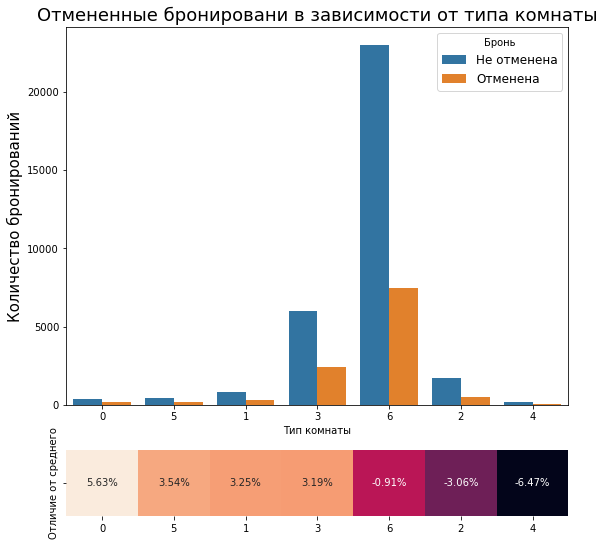

In [81]:
ax = get_count_heat(train, 'reserved_room_type')
ax.set_title('Отмененные бронировани в зависимости от типа комнаты', fontsize=18)
ax.set_xlabel('Тип комнаты')

plt.show()

**ВЫВОД:**  
Большинство гостей резервируют самую дорогую комнату класса А. Процент отказов от бронирования номера этого класса приблизительно равен среднему по набору данных.  
Факт бронирования любого другого номера информативен для предсказания.

## Изменения в заказе

In [82]:
train['booking_changes'].value_counts()

0     36150
1      5359
2      1569
3       371
4       138
5        40
6        18
7        17
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64

In [83]:
test['booking_changes'].value_counts()

0     27745
1      3065
2      1160
3       268
4       117
5        29
6        16
7         5
18        1
15        1
16        1
14        1
8         1
11        1
10        1
Name: booking_changes, dtype: int64

Объединим все значения >4 в одну группу, закодируем числом 5.

In [84]:
full_train['booking_changes'] = np.where(full_train['booking_changes'] > 4,
                                         5,
                                         full_train['booking_changes'])
train['booking_changes'] = np.where(train['booking_changes'] > 4,
                                    5,
                                    train['booking_changes'])

test['booking_changes'] = np.where(test['booking_changes'] > 4,
                                   5,
                                   test['booking_changes'])

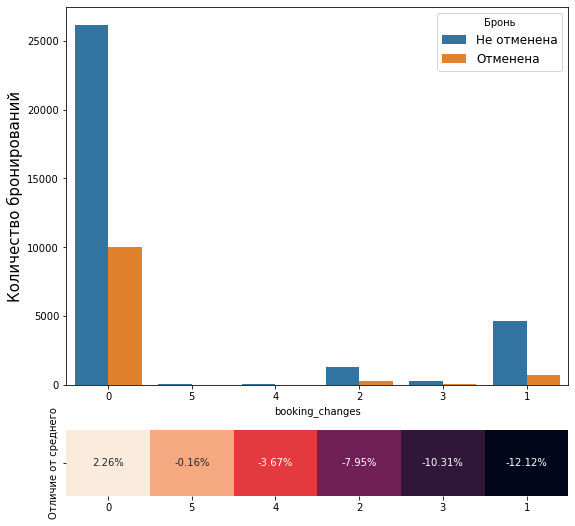

In [85]:
ax = get_count_heat(train, 'booking_changes')

**ВЫВОД:**  
Заказы без изменений отменяются чащу других.  
Далее работает правило "чем меньше изменений, тем меньше вероятность отмены бронирования".

## Время ожидания

In [86]:
train['days_in_waiting_list'].value_counts()

0      43206
63        42
15        19
87        18
48        16
       ...  
55         1
13         1
62         1
160        1
167        1
Name: days_in_waiting_list, Length: 97, dtype: int64

Рассмотрим отдельно заказы, подтвержденные в этот же день, и отдельно все остальные заказы.

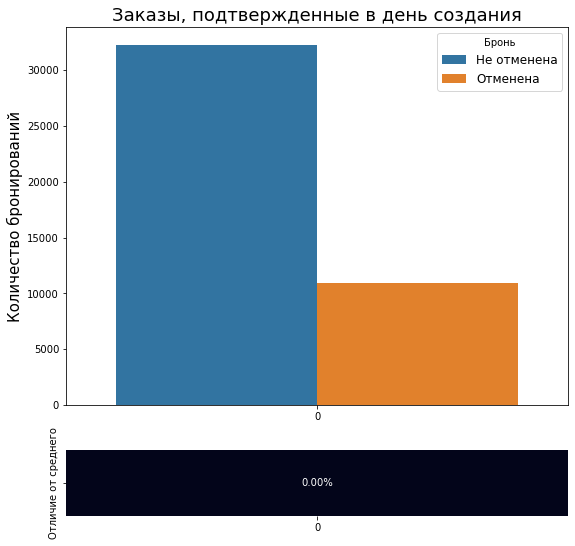

In [87]:
ax = get_count_heat(train[train['days_in_waiting_list'] == 0], 'days_in_waiting_list')
ax.set_title('Заказы, подтвержденные в день создания', fontsize=18)
ax.set_xlabel('')
plt.show()

In [88]:
(train.shape[0] - train[train['days_in_waiting_list'] != 0].shape[0]) / train.shape[0]

0.9890124982832028

**ВЫВОД:**  
98,9% заказов подтверждаются в день создания. Для них % отмен равен среднему по всей выборке.

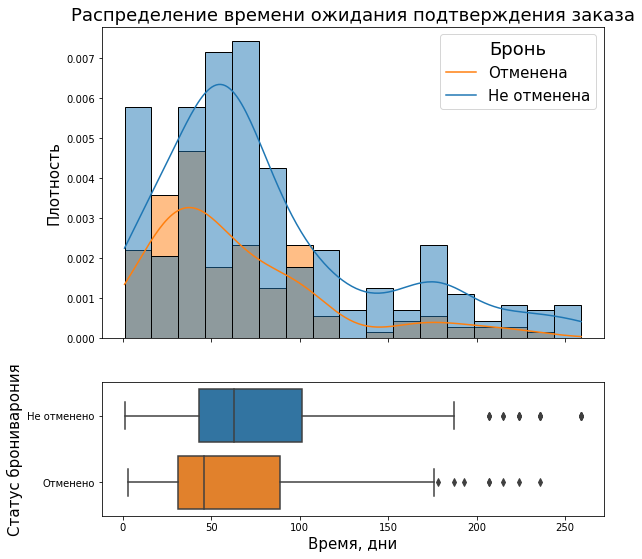

In [89]:
ax = get_hist_box(train[train['days_in_waiting_list'] != 0], 'days_in_waiting_list')
ax[0].set_title('Распределение времени ожидания подтверждения заказа', fontsize=18)
plt.show()

**ВЫВОД:**  
Если заказ не подтвержден одним днем, то чем дольше думают, тем с меньшей вероятностью отменят.  
Скорее всего признак будет не информативен при построении модели.

## Тип клиента

In [90]:
train['customer_type'].value_counts()

Transient          35278
Transient-Party     6277
Contract            1873
Group                258
Name: customer_type, dtype: int64

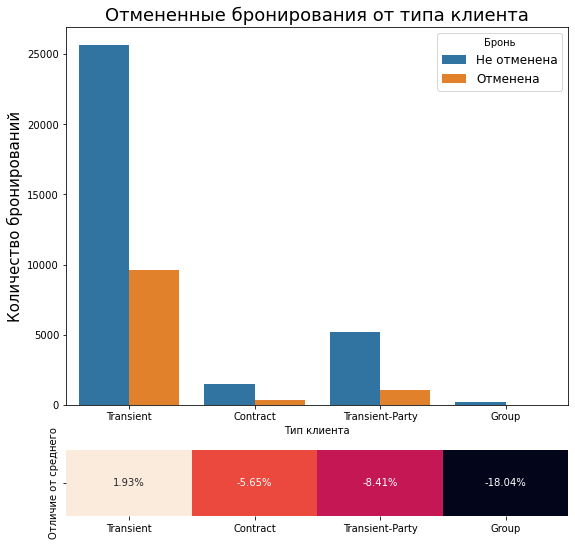

In [91]:
ax = get_count_heat(train, 'customer_type')
ax.set_title('Отмененные бронирования от типа клиента', fontsize=18)
ax.set_xlabel('Тип клиента')
plt.show()

**ВЫВОД:**  
Большинство клиентов имеют тип Transient. Такие отменяют немного чаще среднего.  
Другие типы клиентов не так многоочисленны, но процент отмен в них ниже среднего.

## Парковочные места

In [92]:
train['required_car_parking_spaces'].value_counts()

0    40089
1     3585
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

In [93]:
test['required_car_parking_spaces'].value_counts()

0    30935
1     1468
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64

Преобразуем в бинарный признак: "требуется праковочное место".

In [94]:
full_train['required_car_parking_spaces'] = np.where(full_train['required_car_parking_spaces'] > 0,
                                                     1,
                                                     0)
train['required_car_parking_spaces'] = np.where(train['required_car_parking_spaces'] > 0,
                                                1,
                                                0)

test['required_car_parking_spaces'] = np.where(test['required_car_parking_spaces'] > 0,
                                               1,
                                               0)

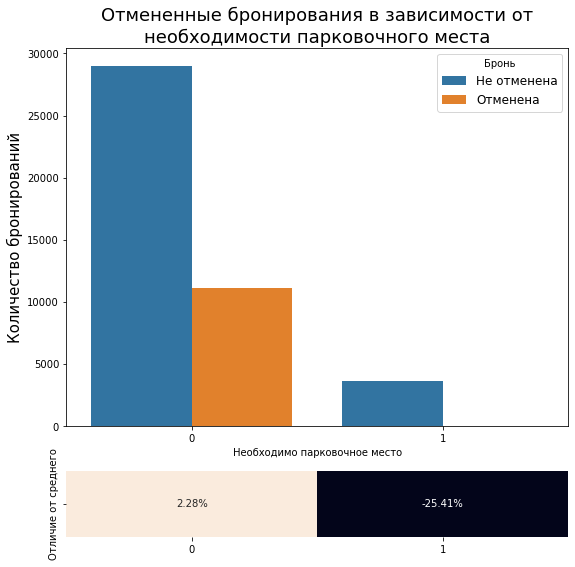

In [95]:
ax = get_count_heat(train, 'required_car_parking_spaces')
ax.set_title('Отмененные бронирования в зависимости от\nнеобходимости парковочного места', fontsize=18)
ax.set_xlabel('Необходимо парковочное место')
plt.show()

**ВЫВОД:**  
Те, кому необходимо место для парковки, никогда не отменяют бронирование, но большинству такое место не требуется.

## Особые требования

In [96]:
train['total_of_special_requests'].value_counts()

0    22369
1    14526
2     5750
3      933
4       98
5       10
Name: total_of_special_requests, dtype: int64

In [97]:
test['total_of_special_requests'].value_counts()

0    17338
1    10037
2     3988
3      907
4      124
5       18
Name: total_of_special_requests, dtype: int64

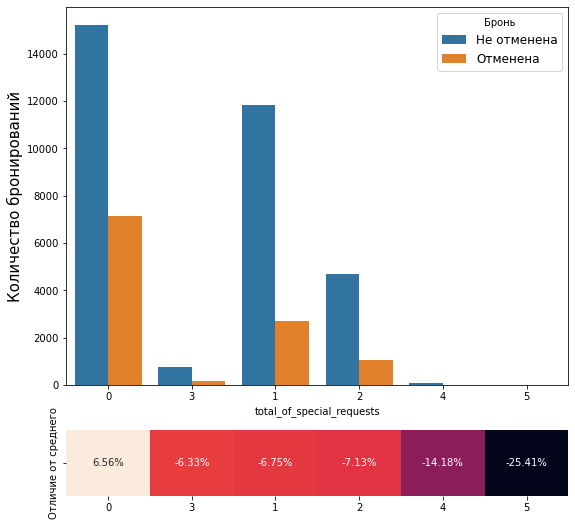

In [98]:
ax = get_count_heat(train, 'total_of_special_requests')

**ВЫВОД:**  
Чаще всего отменяют бронь клиенты без особых требований.  
В целом наблюдается тенденция "чем больше требований, тем меньше вероятность отмены".

# Шаг 3. Вычислите бизнес-метрику

In [99]:
calculate_profit(train)
print(f"Прибыль отеля за 2015, 2016 год без введения системы депозитов составляет: {train['profit'].sum():0.2f} у.е.")

Прибыль отеля за 2015, 2016 год без введения системы депозитов составляет: 60225530.00 у.е.


In [100]:
calculate_profit(test)
no_ml_profit = test['profit'].sum()
print(f"Прибыль отеля за 2017 год без введения системы депозитов составит: {no_ml_profit:0.2f} у.е.")

Прибыль отеля за 2017 год без введения системы депозитов составит: 28257360.00 у.е.


# Шаг 4. Разработка модели ML

**Выбор ML-метрики:**  
В задаче наблюдается дисбаланс классов, следовательно accuracy не подходит.  
Ложноположительные результаты - когда мы просим человека, который не отменит бронирование, внести депозит - не приносят нам убытков, только небольшой репутационный удар и отток "неуверенных" клиентов.  
Основная задача - избежать ложнотрицательных результатов и предсказать как можно больше клиентов, которые откажутся от бронирования.  
Поэтому для в данной задачи выберем ML-метрики в порядке убывания важности: **F1-мера** класса "1", **recall** класса "1".

## Финальные приготовления

Выкинем лишние столбцы.

In [101]:
test = test.drop(['night_price', 'service_price', 'profit'], axis=1)

Подготовимся к преобразованию типов данных и кодированию категориальных признаков.

In [102]:
ohe_feats = ['meal',
             'country',
             'distribution_channel',
             'customer_type']
ord_feats = ['arrival_date_month']
cat_feats = full_train.select_dtypes(include='object').columns
num_feats = full_train.select_dtypes(exclude='object').columns

Проведем преобразование типов данных для оптимизации их хранения.  
Закодируем категорианльные признаки.

In [103]:
full_train[cat_feats] = full_train[cat_feats].astype('category')
test[cat_feats] = test[cat_feats].astype('category')

full_train[num_feats] = full_train[num_feats].astype('int').apply(pd.to_numeric, downcast='unsigned')
test[num_feats] = test[num_feats].astype('int').apply(pd.to_numeric, downcast='unsigned')

# внутри catboost реализовано кодирование категориальных переменных,
# поэтому нужно сохранить датасеты до кодирования
catboost_train = copy.deepcopy(full_train)
catboost_test = copy.deepcopy(test)

full_train = pd.get_dummies(data=full_train,
                            columns=ohe_feats,
                            drop_first=True)
test = pd.get_dummies(data=test, columns=ohe_feats, drop_first=True)

ord_enc = OrdinalEncoder()
full_train[ord_feats] = ord_enc.fit_transform(full_train[ord_feats]).astype('uint8')
test[ord_feats] = ord_enc.transform(test[ord_feats]).astype('uint8')

Полная обучающая выборка.

In [104]:
X_train_full = full_train.drop(['is_canceled', 'total_nights'], axis=1)
y_train_full = full_train['is_canceled']

Исключим дубликаты из обучающей выборки.

In [105]:
X_train_no_dup = X_train_full.drop_duplicates()
y_train_no_dup = y_train_full[X_train_no_dup.index]

Тестовая выборка

In [106]:
X_test = test.drop(['is_canceled', 'arrival_date_season_coef', 'total_nights'], axis=1)
y_test = test['is_canceled']

In [107]:
if ((X_train_full.shape[1] == X_test.shape[1])
    and (X_train_no_dup.shape[1] == X_test.shape[1])):
    print(
        'Размерности обучающих и тестовой выборки совападают.\nМожно строить модели!'
    )
else:
    print('Ищи ошибки.')

Размерности обучающих и тестовой выборки совападают.
Можно строить модели!


## Случайный лес

Настроим гиперпараметры на лучший ROC-AUC, а потом выберем порог отсечки для максимизации F-меры.

In [108]:
# %%time
# rf = RandomForestClassifier(class_weight='balanced', 
#                             n_jobs=-1, 
#                             random_state=45)
# params = {'n_estimators': [100, 200, 300, 400],
#           'max_features': [2, 'log2', 6, 8],
#           'max_depth': [4, 5, 6, 7]}

# gs_cv = GridSearchCV(rf, params, scoring='roc_auc', cv=3, n_jobs=-1)
# gs_cv.fit(X_train_full, y_train_full)
# print(f"Лучшие параметры на кросс-валидации: {gs_cv.best_params_}")
# final_rf = gs_cv.best_estimator_

Wall time: 5min 10s.  
  
Лучшие гиперпараметры, полученные при поиске по сетке:  
`n_estimators`= 200,  
`max_features`= 'log2',  
`max_depth`= 7.

In [109]:
final_rf = RandomForestClassifier(n_estimators=200,
                                  max_features='log2',
                                  max_depth=7,
                                  class_weight='balanced', 
                                  n_jobs=-1, 
                                  random_state=45)

In [110]:
rf_pred_proba = cross_val_predict(final_rf,
                                  X_train_full,
                                  y_train_full,
                                  method='predict_proba',
                                  n_jobs=-1)[:, 1]
# rf_pred, treshold = tune_threshold(y_train_full, rf_pred_proba)

Лучший порог: 0.41,  
Лучшая f1-мера: 0.6636997792494481.

In [111]:
rf_pred = (rf_pred_proba > 0.41).astype('int')

## Логистическая регрессия

In [112]:
scaler = StandardScaler()

X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled_full = scaler.transform(X_test)

X_train_no_dup_scaled = scaler.fit_transform(X_train_no_dup)
X_test_scaled_no_dup = scaler.transform(X_test)

In [113]:
# %%time
# lr = LogisticRegression(penalty='elasticnet',
#                         solver='saga',
#                         class_weight='balanced', 
#                         n_jobs=-1, 
#                         random_state=45)
# params = {'C': np.logspace(-3, -1, 5),
#           'l1_ratio': np.linspace(0, 1, 10)}

# gs_cv = GridSearchCV(lr, params, scoring='roc_auc', cv=3, n_jobs=-1)
# gs_cv.fit(X_train_full_scaled, y_train_full)
# print(f"Лучшие параметры на кросс-валидации: {gs_cv.best_params_}")
# final_lr = gs_cv.best_estimator_

Wall time: 53.1 s.  
  
Лучшие гиперпараметры, полученные на кросс-валидации:  
`l1_ratio`= 1, значит можно заменить регуляризацию на L1,  
`C`= 0.03162277660168379.  

In [114]:
final_lr = LogisticRegression(penalty='l1',
                              C=0.03162277660168379,
                              solver='saga',
                              class_weight='balanced', 
                              n_jobs=-1, 
                              random_state=45)

In [115]:
lr_pred_proba = cross_val_predict(final_lr,
                                  X_train_full_scaled,
                                  y_train_full,
                                  method='predict_proba',
                                  n_jobs=-1)[:, 1]
# lr_pred, treshold = tune_threshold(y_train_full, lr_pred_proba)

Лучший порог: 0.5  
Лучшая f1-мера: 0.6725485456449923

In [116]:
lr_pred = (lr_pred_proba > 0.5).astype('int')

## Градиентный бустинг

In [117]:
%%time
X_catboost_train = catboost_train.drop(['is_canceled', 'total_nights'], axis=1)
X_catboost_test = catboost_test.drop(
    ['is_canceled', 'total_nights', 'arrival_date_season_coef'], axis=1)

cat_feats = [
    'arrival_date_month', 'adults', 'children', 'reserved_room_type', 'meal',
    'country', 'distribution_channel', 'customer_type'
]

# boost = CatBoostClassifier(verbose=500,
#                            auto_class_weights='Balanced',
#                            cat_features=cat_feats,
#                            one_hot_max_size=4,
#                            eval_metric='AUC')

# params = {'depth': [1, 2, 3],
#           'iterations': [2500, 2750, 3000]}

# gs_cv = GridSearchCV(boost, params, scoring='roc_auc', cv=3, n_jobs=-1)
# gs_cv.fit(X_catboost_train, y_train_full)
# print(f"Лучшие параметры на кросс-валидации: {gs_cv.best_params_}")
# final_boost = gs_cv.best_estimator_

Wall time: 5 ms


Wall time: 37min 49s.  
  
Лучшие гиперпараметры, полученные на кросс-валидации:  
`depth`= 2,  
`iterations`= 2750.

In [118]:
final_boost = CatBoostClassifier(depth=2,
                                 iterations=2750,
                                 verbose=500,
                                 auto_class_weights='Balanced',
                                 cat_features=cat_feats,
                                 one_hot_max_size=4,
                                 eval_metric='F1')

In [119]:
%%time
cb_pred_proba = cross_val_predict(final_boost,
                                  X_catboost_train,
                                  y_train_full,
                                  method='predict_proba',
                                  n_jobs=-1,
                                  cv=3)[:, 1]
# cb_pred, treshold = tune_threshold(y_train_full, cb_pred_proba)

Wall time: 3min 26s


Лучший порог: 0.44,  
Лучшая f1-мера: 0.5805349380208433

In [120]:
cb_pred = (cb_pred_proba > 0.44).astype('int')

## Выбор ML-модели

Рассмотрим метрики классификации моделей.

              precision    recall  f1-score   support

           0       0.84      0.66      0.74     41067
           1       0.58      0.78      0.66     23996

    accuracy                           0.71     65063
   macro avg       0.71      0.72      0.70     65063
weighted avg       0.74      0.71      0.71     65063



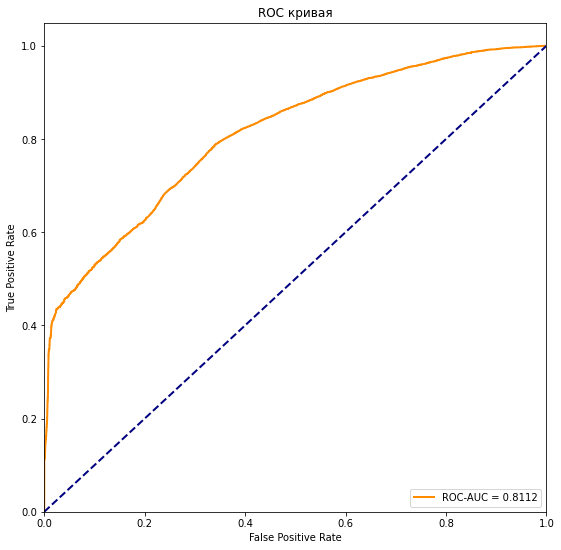

In [121]:
print(classification_report(y_train_full, rf_pred))
plot_roc_auc(y_train_full, rf_pred_proba)

              precision    recall  f1-score   support

           0       0.81      0.78      0.80     41067
           1       0.65      0.70      0.67     23996

    accuracy                           0.75     65063
   macro avg       0.73      0.74      0.74     65063
weighted avg       0.75      0.75      0.75     65063



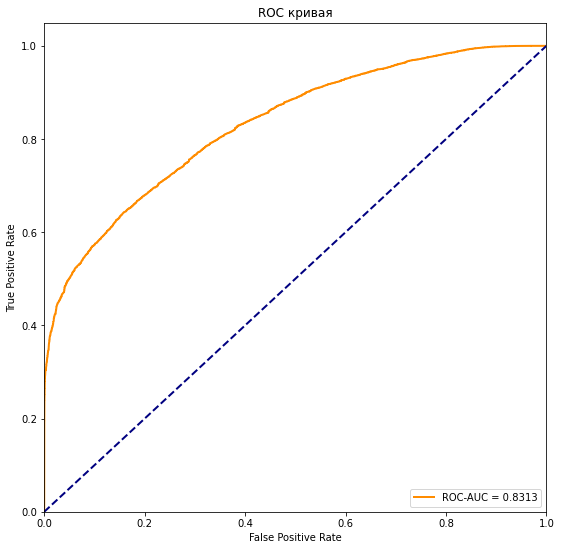

In [122]:
print(classification_report(y_train_full, lr_pred))
plot_roc_auc(y_train_full, lr_pred_proba)

              precision    recall  f1-score   support

           0       0.76      0.67      0.71     41067
           1       0.53      0.64      0.58     23996

    accuracy                           0.66     65063
   macro avg       0.65      0.66      0.65     65063
weighted avg       0.68      0.66      0.67     65063



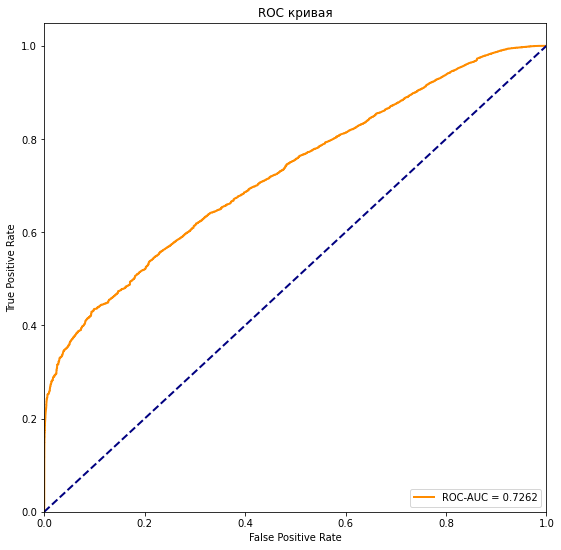

In [123]:
print(classification_report(y_train_full, cb_pred))
plot_roc_auc(y_train_full, cb_pred_proba)

**ВЫВОД:**  
Согласно выбранной ML-метрике лучшей моделью является модель логистической регрессии. Предсказания этой модели будут использованы для расчета прибыли.  
  
*В качестве эксперимента проверим все три модели на тестовой выборке, потому что мое чутье будущего датасатаниста подсказывает, что меня ждет сюрприз.*

## Предсказание

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     19821
           1       0.69      0.66      0.67     12591

    accuracy                           0.75     32412
   macro avg       0.74      0.73      0.74     32412
weighted avg       0.75      0.75      0.75     32412



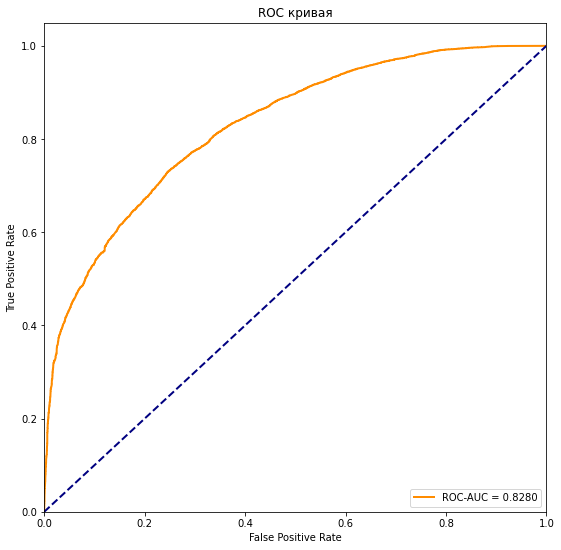

In [124]:
final_lr.fit(X_train_full_scaled, y_train_full)

pred_proba = final_lr.predict_proba(X_test_scaled_full)[:, 1]
pred = (pred_proba > 0.5).astype('int')

print(classification_report(y_test, pred))
plot_roc_auc(y_test, pred_proba)

## Расчет прибыли при использовании ML-моделей

In [125]:
test_w_pred = test[['total_nights', 'reserved_room_type', 'arrival_date_season_coef', 'is_canceled']]
test_w_pred['lr_predictions'] = pred
test_w_pred['dummy_predictions'] = 1
test_w_pred['mega_dummy_predictions'] = 0

In [126]:
calculate_profit(test_w_pred, with_pred=True)

Предположим, что 50% клиентов, которым предложили внести депозит, отказались от услуг отеля.

In [127]:
state = np.random.RandomState()
profit_dist = []
for _ in range(1000):
    reject_booking_ind = list(test_w_pred
                              .query('lr_predictions == 1')
                              .sample(frac=0.5,
                                      replace=True,
                                      random_state=state)
                              .index)
    profit_dist.append(test_w_pred
                       .drop(reject_booking_ind)['profit']
                       .sum() - BUDGET)

print(f"Средняя прибыль при внедрении ML-модели: {np.mean(profit_dist):0.2f}")
print(f"Средняя прибыль без внедрения ML-модели: {no_ml_profit:0.2f}")
print(f"Увеличение прибыли от внедрения ML-модели: {np.mean(profit_dist) - no_ml_profit:0.2f}")

Средняя прибыль при внедрении ML-модели: 35416128.86
Средняя прибыль без внедрения ML-модели: 28257360.00
Увеличение прибыли от внедрения ML-модели: 7158768.86


Расчитаем прибыль, если всем клиентам предлагать внести депозит.

In [128]:
calculate_profit(test_w_pred, with_pred=True, pred_feat_name='dummy_predictions')

state = np.random.RandomState()
profit_dist = []
for _ in range(1000):
    reject_booking_ind = list(test_w_pred
                              .query('dummy_predictions == 1')
                              .sample(frac=0.5,
                                      replace=True,
                                      random_state=state)
                              .index)
    profit_dist.append(test_w_pred.drop(reject_booking_ind)['profit']
                       .sum() - BUDGET)
    
print(f"Средняя прибыль требовании депозита с каждого: {np.mean(profit_dist):0.2f}")
print(f"Средняя прибыль без внедрения ML-модели: {no_ml_profit:0.2f}")
print(f"Увеличение прибыли от такой стратегии: {np.mean(profit_dist) - no_ml_profit:0.2f}")

Средняя прибыль требовании депозита с каждого: 25981350.39
Средняя прибыль без внедрения ML-модели: 28257360.00
Увеличение прибыли от такой стратегии: -2276009.61


**ВЫВОД:**  
Таким образом, внедрение модели машинного обучения позволит увеличить прибыль приблизительно на **7,160 млн**, в то время как простое требование депозита с каждого клиента принесет **2,280 млн убытка**. Польза от использования ML-модели на лицо!

# Шаг 5. Выявите признаки «ненадёжного» клиента

In [129]:
lr_feat_imp = (pd.DataFrame(np.abs(final_lr.coef_).reshape(-1, 1),
                            index=X_train_no_dup.columns,
                            columns=['Feature Name'])
               .sort_values(by='Feature Name', ascending=False))
lr_feat_imp.head(5)

,Feature Name
required_car_parking_spaces,1.365519
previous_cancellations_bool,1.156366
country_PRT,1.004871
customer_type_Transient,0.607119
lead_time,0.585097


На основе именно этих признаков модель по большей части принимала решение.  
  
Таким образом, ***ненадежный клиент***:  
1. Не заказывает парковочное место;  
2. Ранее уже отменял бронирование;  
3. Португалец;
4. Транзитный клиент;
5. Бронирует отель заранее.

При построении модели использовалась L1-регуляризация, это значит, что какие-то признаки модель сочла ненужными для классификации и присвоила им вес 0. Интересно было бы на них взгялнуть.

In [130]:
lr_feat_imp[lr_feat_imp['Feature Name'] == 0]

,Feature Name
arrival_date_month,0.0
country_IRL,0.0
country_NLD,0.0
babies,0.0


Не важно в каком месяце вы бронируете отель и есть ли у вас младенцы на руках. Также модель не обратит внимание на тот факт, что вы из Ирландии или из Недерландов.

# Шаг 6. Напишите общий вывод

Самый общий вывод: нужно внести изменения в бизнес-метрику. Потому что она никак не "наказывает" нас за то, что мы попросили внести депозит клиента, который не отменил бы бронирование. Поэтому наилучшим с точки зрения *предложенной* бизнес-метрики является простейшее решение - "Бронь только с депозитом".  
Более или менее очевидно, что в реальной жизни это не так. Зачем клиенту, который еще не определился и думает, какой отель ему выбрать, вносить невозвратный депозит? Эти клиенты от нас уйдут. Что в некотором смысле даже хуже, чем если бы мы понесли убытки при отмене его заказа, потому что вероятно, что он вообще не будет рассматривать наш отель в дальнейшем.  
Если не брать в расчет такое тривиальное решение, то наилучшей моделью будет случайный лес: он верно нашел 95% ненадежных клиентов и 45% надежных.
  
Я считаю, что нужно провести исследование, как часто решаюшим фактором об отмене бронирования является именно необходимость внести депозит. Реализовать, думаю, можно при помощи А/В-тестов. После научиться предсказывать именно таких клиентов: которые не отменили бы бронирование, если бы мы не предложили им внести депозит.

Если рассматривать видоизмененную задачу, в которой верное нахождение надежных клиентов тоже имеет значение, то наилучшей моделью является градиентый бустинг в реализации CatBoost.  
Этой моделью удалось достичь очень сбалансированного и стабильного результата: найдено 67% всех ненадежных клиентов, 72% из тех, кто был назван ненадежным на самом деле таковым и являлся. Верно обнаружено 83% надежных клиентов, всего лишь 20% клиентов, который были классифоцированы как надежные в итоге отменили бронирование.  
Эти значения можно увеличить, если использовать большие вычислительные мощности для настройки гиперпараметров модели и ее обучения.

# P.S

Рассмотрим работу других моделей на тестовой выборке. Рассчитаем прибыль.

              precision    recall  f1-score   support

           0       0.80      0.77      0.79     19821
           1       0.66      0.70      0.68     12591

    accuracy                           0.75     32412
   macro avg       0.73      0.74      0.74     32412
weighted avg       0.75      0.75      0.75     32412



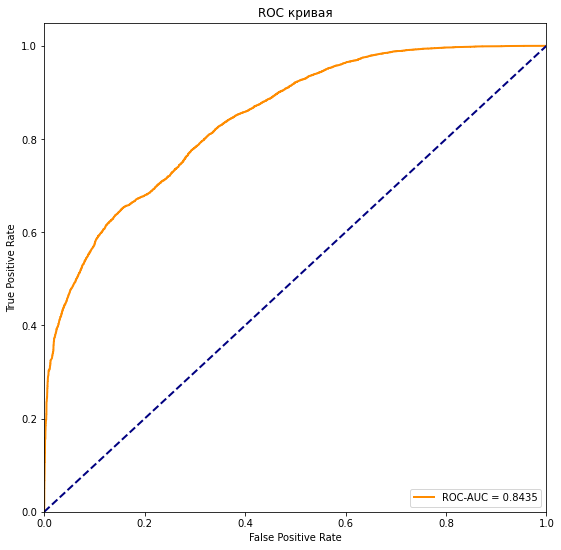

In [131]:
final_rf.fit(X_train_full, y_train_full)

pred_proba_1 = final_rf.predict_proba(X_test)[:, 1]
pred_1 = (pred_proba_1 > 0.41).astype('int')

print(classification_report(y_test, pred_1))
plot_roc_auc(y_test, pred_proba_1)

**ВЫВОД:**  
Очень даже неплохо.  
Эта модель показала себя лучше логистической регрессии, которая уже ушла в прод: выше F-мера класса "1", выше полнота для обоих классов.

Learning rate set to 0.02423
0:	learn: 0.7073585	total: 187ms	remaining: 8m 34s
500:	learn: 0.8078245	total: 21.5s	remaining: 1m 36s
1000:	learn: 0.8132587	total: 43.3s	remaining: 1m 15s
1500:	learn: 0.8156026	total: 1m 6s	remaining: 55.3s
2000:	learn: 0.8170280	total: 1m 29s	remaining: 33.5s
2500:	learn: 0.8201124	total: 1m 52s	remaining: 11.2s
2749:	learn: 0.8206132	total: 2m 4s	remaining: 0us
              precision    recall  f1-score   support

           0       0.82      0.78      0.80     19821
           1       0.68      0.73      0.70     12591

    accuracy                           0.76     32412
   macro avg       0.75      0.76      0.75     32412
weighted avg       0.76      0.76      0.76     32412



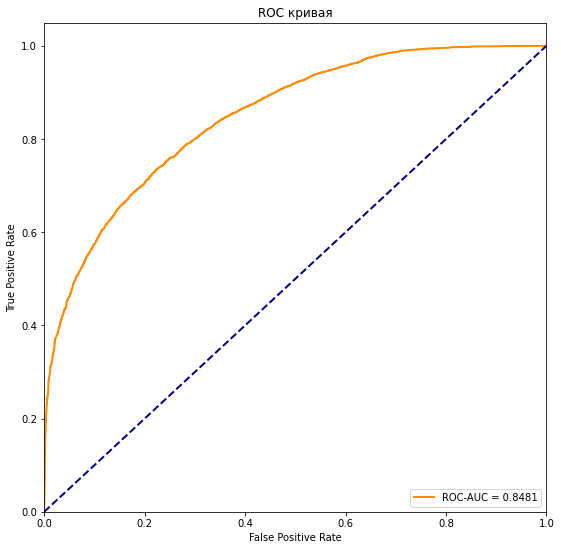

In [132]:
final_boost.fit(X_catboost_train, y_train_full)

pred_proba_2 = final_boost.predict_proba(X_catboost_test)[:, 1]
pred_2 = (pred_proba_2 > 0.44).astype('int')

print(classification_report(y_test, pred_2))
plot_roc_auc(y_test, pred_proba_2)

**ВЫВОД:**  
О-оу! А после кросс-валидации эта модель была выкинута в мусорку из-за своих крошечных метрик.

Посмотрим насколько больше можно было бы заработать, если бы удалось избежать этой ошибки с выбором модели.

In [133]:
test_w_pred = test[['total_nights', 'reserved_room_type', 'arrival_date_season_coef', 'is_canceled']]
test_w_pred['rf_predictions'] = pred_1
test_w_pred['cb_predictions'] = pred_2
test_w_pred['dummy_predictions'] = 1
test_w_pred['mega_dummy_predictions'] = 0

In [134]:
calculate_profit(test_w_pred, with_pred=True, pred_feat_name='rf_predictions')

Случайный лес

In [135]:
state = np.random.RandomState()
profit_dist = []
for _ in range(1000):
    reject_booking_ind = list(test_w_pred
                              .query('rf_predictions == 1')
                              .sample(frac=0.5,
                                      replace=True,
                                      random_state=state)
                              .index)
    profit_dist.append(test_w_pred
                       .drop(reject_booking_ind)['profit']
                       .sum() - BUDGET)

print(f"Средняя прибыль при внедрении ML-модели: {np.mean(profit_dist):0.2f}")
print(f"Средняя прибыль без внедрения ML-модели: {no_ml_profit:0.2f}")
print(f"Увеличение прибыли от внедрения ML-модели: {np.mean(profit_dist) - no_ml_profit:0.2f}")

Средняя прибыль при внедрении ML-модели: 35218705.78
Средняя прибыль без внедрения ML-модели: 28257360.00
Увеличение прибыли от внедрения ML-модели: 6961345.78


**ВЫВОД:**  
Заработали бы на примерно на 200 000 меньше.

Бустинг.

In [136]:
state = np.random.RandomState()
profit_dist = []
for _ in range(1000):
    reject_booking_ind = list(test_w_pred
                              .query('cb_predictions == 1')
                              .sample(frac=0.5,
                                      replace=True,
                                      random_state=state)
                              .index)
    profit_dist.append(test_w_pred
                       .drop(reject_booking_ind)['profit']
                       .sum() - BUDGET)

print(f"Средняя прибыль при внедрении ML-модели: {np.mean(profit_dist):0.2f}")
print(f"Средняя прибыль без внедрения ML-модели: {no_ml_profit:0.2f}")
print(f"Увеличение прибыли от внедрения ML-модели: {np.mean(profit_dist) - no_ml_profit:0.2f}")

Средняя прибыль при внедрении ML-модели: 35771183.27
Средняя прибыль без внедрения ML-модели: 28257360.00
Увеличение прибыли от внедрения ML-модели: 7513823.27


**ВЫВОД:**  
А эта модель принесла бы на полмиллиона больше. Имея под рукой большие вычислительные мощности скорее всего удалось бы подобрать гиперпараметры и обучить модель еще точнее, что увеличило бы прибыль.